# Summary

This notebook is to test the functions that build a meta neural dataset, i.e. across session integration of trials.

---
# Setup

In [1]:
#%%
import numpy
import xarray
import pandas
import matplotlib.pyplot as plt
import matplotlib
import logging
import datetime

from popy.io_tools import *
from popy.behavior_data_tools import *
from popy.neural_data_tools import *
from popy.plotting.plotting_tools import *
from popy.config import PROJECT_PATH_LOCAL

In [2]:
PARAMS = {
    'floc': os.path.join(PROJECT_PATH_LOCAL, 'data', 'processed', 'neural_data', 'meta_rates_20'),
    'label': 'history_of_feedback',
    'm': 20
    }

# Do statistics of number of units

In [3]:
info_df = pandas.read_csv(os.path.join(PARAMS['floc'], 'info_df.csv'), dtype={'session': str})
info_df

,monkey,session,unit,history_of_feedback_0.0,history_of_feedback_1.0,history_of_feedback_2.0,history_of_feedback_3.0,history_of_feedback_4.0,history_of_feedback_5.0,history_of_feedback_6.0,history_of_feedback_7.0
0,ka,010720,ka_010720_LPFC_04_01,64.0,55.0,57.0,46.0,55.0,48.0,46.0,94.0
1,ka,010720,ka_010720_LPFC_05_01,64.0,55.0,57.0,46.0,55.0,48.0,46.0,94.0
2,ka,010720,ka_010720_LPFC_05_02,64.0,55.0,57.0,46.0,55.0,48.0,46.0,94.0
3,ka,010720,ka_010720_LPFC_05_03,64.0,55.0,57.0,46.0,55.0,48.0,46.0,94.0
4,ka,010720,ka_010720_LPFC_06_01,64.0,55.0,57.0,46.0,55.0,48.0,46.0,94.0
...,...,...,...,...,...,...,...,...,...,...,...
4105,po,310822,po_310822_MCC_12_02,72.0,41.0,40.0,51.0,41.0,49.0,52.0,67.0
4106,po,310822,po_310822_MCC_12_01,72.0,41.0,40.0,51.0,41.0,49.0,52.0,67.0
4107,po,310822,po_310822_MCC_13_01,10.0,9.0,9.0,23.0,8.0,22.0,23.0,26.0
4108,po,310822,po_310822_MCC_13_02,60.0,32.0,31.0,28.0,33.0,27.0,29.0,41.0


In [4]:
# count number of units per monkey
print("Number of units per monkey")
print(info_df.groupby('monkey').size())

# count number of unique sessions per monkey
print("Number of unique sessions per monkey")
print(info_df.groupby('monkey')['session'].nunique())

# conut mean number of units per session
print("Mean number of units per session")
print(info_df.groupby('monkey')['session'].value_counts().groupby(level=0).mean())



Number of units per monkey
monkey
ka    2174
po    1936
dtype: int64
Number of unique sessions per monkey
monkey
ka    62
po    54
Name: session, dtype: int64
Mean number of units per session
monkey
ka    35.064516
po    35.851852
Name: count, dtype: float64


m=10 predicts 3684 units
m=20 predicts 2559 units


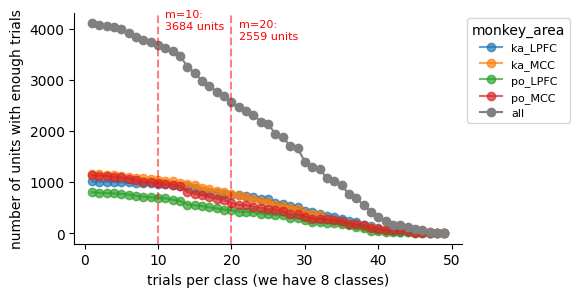

In [5]:
# plot 'm', an arbitrary number against the number of units (i.e. rows) where the minimum of columns starting with 'history_of_feedback_' is greater or equal to m

ms = numpy.arange(1, 50, 1)
info_df[f"{PARAMS['label']}_minimum"] = info_df.filter(like=PARAMS['label']).min(axis=1)

n_units_above_m = []
for m in ms:
    for monkey in ['ka', 'po']:
        for area in ['LPFC', 'MCC']:
            n_units = np.sum(
                (info_df["monkey"] == monkey) & 
                (info_df["unit"].str.split('_', expand=True)[2] == area) &
                (info_df[f"{PARAMS['label']}_minimum"] >= m)
            )       
            n_units_above_m.append({'monkey': monkey, 'area': area, 'm': m, 'n_units': n_units})
n_units_above_m = pandas.DataFrame(n_units_above_m)


# plot
fig, ax = plt.subplots(figsize=(5, 3))

n_units_sum = []
for monkey in ['ka', 'po']:
    for area in ['LPFC', 'MCC']:
        subset = n_units_above_m[(n_units_above_m['monkey'] == monkey) & (n_units_above_m['area'] == area)]
        ax.plot(subset['m'], subset['n_units'], label=f"{monkey}_{area}", marker='o', alpha=0.7)
        n_units_sum.append(subset['n_units'].values)
n_units_sum = np.sum(np.array(n_units_sum), axis=0)
        
# plot all monkeys and areas together - sum 'n_units' across monkeys and areas for a given 'm'
ax.plot(subset['m'], n_units_sum, label='all', marker='o', color='grey')

print(f"m=10 predicts {n_units_sum[9]} units")
print(f"m=20 predicts {n_units_sum[19]} units")

ax.legend(title='monkey_area', loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
ax.set_xlabel('trials per class (we have 8 classes)')
ax.set_ylabel('number of units with enough trials')    
ax.axvline(x=10, color='r', linestyle='--', alpha=.5)
ax.text(11, 4000, f'm=10: \n{n_units_sum[9]} units', color='r', fontsize=8)
ax.axvline(x=20, color='r', linestyle='--', alpha=.5)
ax.text(21, 3800, f'm=20: \n{n_units_sum[19]} units', color='r', fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Look at units across sessions - validation

In [6]:
# merge along unit axis
meta_ds = xr.open_dataset(PARAMS['floc'] + '/meta_rates.nc')

meta_ds

<xarray.Dataset>
Dimensions:              (unit: 2559, time: 1500, trial_id: 160)
Coordinates:
    unit_id_original     (unit) int64 ...
    channel              (unit) int64 ...
    monkey               (unit) object ...
    session              (unit) object ...
    area                 (unit) object ...
    subregion            (unit) object ...
  * time                 (time) float64 -7.5 -7.49 -7.48 ... 7.47 7.48 7.49
    epoch                (time) float64 ...
  * unit                 (unit) object 'ka_010720_LPFC_04_01' ... 'po_310822_...
    history_of_feedback  (trial_id) float64 ...
  * trial_id             (trial_id) int64 0 1 2 3 4 5 ... 155 156 157 158 159
Data variables:
    firing_rates         (trial_id, unit, time) float64 ...
Attributes:
    bin_size:  0.01

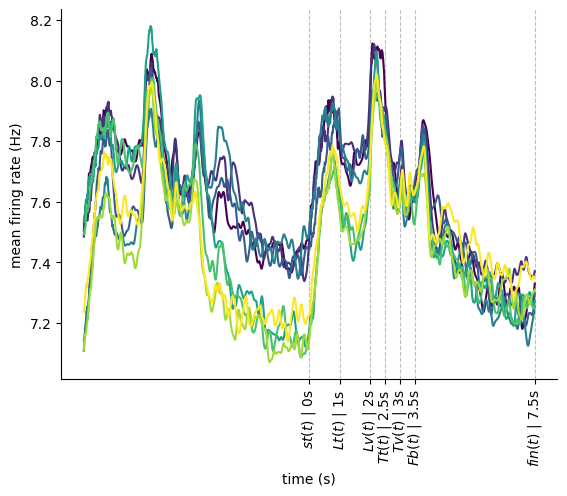

In [7]:

fig, ax = plt.subplots(1, 1)
colors = matplotlib.cm.viridis(np.linspace(0, 1, len(np.unique(meta_ds[PARAMS['label']].values))))

for class_temp in np.sort(np.unique(meta_ds[PARAMS['label']].values)):
    meta_ds_temp = meta_ds.sel(trial_id=meta_ds[PARAMS['label']] == class_temp)
    # get mean firing rate
    firing_rate_mean = meta_ds_temp['firing_rates'].mean(dim='trial_id')
    firing_rate_mean = firing_rate_mean.mean(dim='unit')

    ax.plot(firing_rate_mean['time'], firing_rate_mean, label=f'Class {class_temp}', color=colors[int(class_temp)])

ax.set_xlabel('time (s)')
ax.set_ylabel('mean firing rate (Hz)')

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

plot_keypoints(ax)
ax.grid(axis='x', color='grey', linestyle='--', alpha=0.5)

---
# ...

What we need:
- ...

Parameters:
- num_trials_per_class: number of trials required to use the neuron in the meta dataset (below this number, the neuron is not used)
- n_extra_trials: describes the number of additional trials (i.e. the time window) to be considered, e.g. (-1, 1) means 1 trial before and 1 trial after the trial of interest